In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('cifar10_runs/layer_wise')




## Ideas

![](./assets/1.png)

## Utils

In [26]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

## Device

In [27]:
devices = ["cuda:0", "cuda:1"]

## Preparing data

### Data transforms

In [28]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 32


In [29]:
train_dataset = CIFAR10(root="./data", download=True, train=True, transform=data_transforms)

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,
                          shuffle=True, )

classes = train_dataset.classes

classes


Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

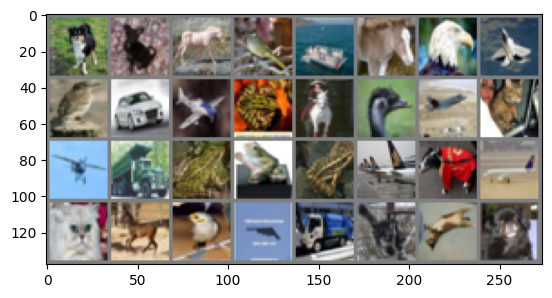

In [30]:
sample = iter(train_loader)

img, label = next(sample)


img_grid = torchvision.utils.make_grid(img)

matplotlib_imshow(img_grid, one_channel=False)

# writer.add_image('CIFAR_10_IMAGES', img_grid)



## Model preparing

In [31]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # VGG16
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 8, kernel_size=5, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
        
        self.fc1 = nn.Linear(400, 60)
        self.fc2 = nn.Linear(120, 42)
        
        # Not apply layer-wise
        self.fc3 = nn.Linear(84, 10)
        
        
        self.submodule_1 = [self.conv1, self.conv1]
        
        self.submodule_2 = [self.conv2, self.conv2]
        
        self.submodule_3 = [self.fc1, self.fc1]
        
        self.submodule_4 = [self.fc2, self.fc2]
        
        
        self.submodules = {
            "conv_module_1":self.submodule_1,
            "conv_module_2":self.submodule_2,
            "fc_module_1":self.submodule_3,
            "fc_module_2":self.submodule_4
        }
    
    def forward(self, x):
        out = x
        for submodule_key, submodule in self.submodules.items():
            partition_out = []
            if submodule_key == "fc_module_1":
                    out = out.reshape(out.size(0), -1)
            for partition in submodule:
                input_partition = out.clone()
                output_part = partition(input_partition)
                partition_out.append(output_part)
               
            # Concatening
            out = torch.cat(partition_out, dim=1)
            if "fc" in submodule_key:
                out = nn.functional.relu(out)
        out = self.fc3(out)
        # out = nn.Softmax(out)    
        
        
        return out

In [32]:
model = LeNet()

# writer.add_graph(model, img)
# writer.close()

# summary(model, (3, 32, 32))

## Helper

In [33]:
# def images_to_probs(net, images):
#     '''
#     Generates predictions and corresponding probabilities from a trained
#     network and a list of images
#     '''
#     output = net(images)
#     # convert output probabilities to predicted class
#     _, preds_tensor = torch.max(output, 1)
#     preds = np.squeeze(preds_tensor.numpy())
#     return preds, [nn.functional.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

# def plot_classes_preds(net, images, labels):
#     '''
#     Generates matplotlib Figure using a trained network, along with images
#     and labels from a batch, that shows the network's top prediction along
#     with its probability, alongside the actual label, coloring this
#     information based on whether the prediction was correct or not.
#     Uses the "images_to_probs" function.
#     '''
#     preds, probs = images_to_probs(net, images)
#     # plot the images in the batch, along with predicted and true labels
#     fig = plt.figure(figsize=(12, 48))
#     for idx in np.arange(4):
#         ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
#         matplotlib_imshow(images[idx], one_channel=True)
#         ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
#             classes[preds[idx]],
#             probs[idx] * 100.0,
#             classes[labels[idx]]),
#                     color=("green" if preds[idx]==labels[idx].item() else "red"))
#     return fig

## Training

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [35]:
running_loss = 0.0
loss_his = []
epochs = 100
for epoch in range(epochs):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # every 1000 mini-batches...
            print(f"Epoch [{epoch}/{epochs}] - part [{i}/{len(train_loader)}] - Loss: {(running_loss / 100):.4f}")
            loss_his.append(running_loss / 100)
            # ...log the running loss
            # writer.add_scalar('training loss',
            #                 running_loss / 1000,
            #                 epoch * len(train_loader) + i)

            # # ...log a Matplotlib Figure showing the model's predictions on a
            # # random mini-batch
            # writer.add_figure('predictions vs. actuals',
            #                 plot_classes_preds(model, inputs, labels),
            #                 global_step=epoch * len(train_loader) + i)
            running_loss = 0.0
print('Finished Training')

Epoch [0/100] - part [99/1563] - Loss: 2.3033
Epoch [0/100] - part [199/1563] - Loss: 2.3002
Epoch [0/100] - part [299/1563] - Loss: 2.2895
Epoch [0/100] - part [399/1563] - Loss: 2.2712
Epoch [0/100] - part [499/1563] - Loss: 2.2157
Epoch [0/100] - part [599/1563] - Loss: 2.1141
Epoch [0/100] - part [699/1563] - Loss: 2.0490
Epoch [0/100] - part [799/1563] - Loss: 2.0033
Epoch [0/100] - part [899/1563] - Loss: 1.9424
Epoch [0/100] - part [999/1563] - Loss: 1.9471
Epoch [0/100] - part [1099/1563] - Loss: 1.9129
Epoch [0/100] - part [1199/1563] - Loss: 1.8848
Epoch [0/100] - part [1299/1563] - Loss: 1.8841
Epoch [0/100] - part [1399/1563] - Loss: 1.8327
Epoch [0/100] - part [1499/1563] - Loss: 1.8346
Epoch [1/100] - part [99/1563] - Loss: 2.8632
Epoch [1/100] - part [199/1563] - Loss: 1.7446
Epoch [1/100] - part [299/1563] - Loss: 1.6987
Epoch [1/100] - part [399/1563] - Loss: 1.7289
Epoch [1/100] - part [499/1563] - Loss: 1.7018
Epoch [1/100] - part [599/1563] - Loss: 1.6817
Epoch [1/1

In [36]:
torch.save(model.state_dict(), "./model_cpu.pth")

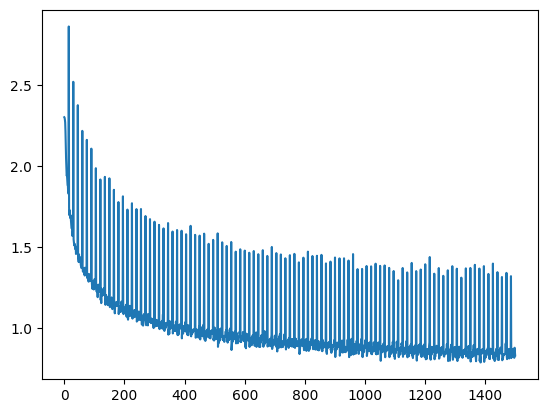

In [37]:
plt.plot(loss_his)

In [47]:
test_dataset = CIFAR10(root="./data", download=False, train=False, transform=data_transforms)

test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,
                          shuffle=False, drop_last=True)

## Testing

In [53]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]  
    n_class_samples = [0 for i in range(10)]  
    
    for images, labels in test_loader:
        images = images
        labels = labels
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        # print(predicted == labels)
        n_correct += torch.sum(predicted == labels)
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if( label == pred):
                n_class_correct[label] +=1
            n_class_samples[label] +=1
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 56.019630432128906 %
Accuracy of airplane: 61.62324649298597 %
Accuracy of automobile: 74.47447447447448 %
Accuracy of bird: 43.44344344344344 %
Accuracy of cat: 38.61584754262788 %
Accuracy of deer: 51.2 %
Accuracy of dog: 33.400200601805416 %
Accuracy of frog: 67.4 %
Accuracy of horse: 63.49047141424273 %
Accuracy of ship: 69.5085255767302 %
Accuracy of truck: 57.0 %
